# Table of Contents

[Introduction](#1)

[Data Exploration](#2)
- [Preprocessing](#2.1)
- [EDA (Exploratory Data Analysis)](#2.2)

[Task 1: Similar Customers](#3)

[Task 2: Is The Customer Likely to Receive Insurance Benefits?](#4)

[Task 3: Linear Regression](#5)

[Task 4: Obfuscating Data](#6)
- [Proof That Data Obfuscation Can Work with Linear Regression](#6.1)
- [Test the Linear Regression With Data Obfuscation](#6.2)

[Conclusion](#7)

[Appendices](#8)

# Introduction <a id = 1></a>

The <u>Sure Tomorrow</u> insurance company wants to solve several tasks with the help of Machine Learning, and I am tasked with solving them.

<b>Task 1:</b> Find customers who are similar to a given customer. This will help the company's agents with marketing.

<b>Task 2:</b> Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?

<b>Task 3:</b> Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.

<b>Task 4:</b> Protect customers' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. (This is called data masking, or data obfuscation.) Furthermore, the data should be protected in such a way that the quality of the machine learning models does not suffer.

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

# Data Exploration <a id = 2></a>

<b>Preprocessing</b> <a id = 2.1></a>

Let's load the data and conduct a basic check to ensure that it is free from obvious issues.

In [2]:
main_df = pd.read_csv('insurance_us.csv')

Now let's rename the columns so that they are written in snake_case.

In [3]:
main_df = main_df.rename(columns = {'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 
                                    'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

I think it is always a good idea to display a random sample of rows from the dataframe in order to see what the rows look like.

In [4]:
main_df.sample(10)

,gender,age,income,family_members,insurance_benefits
3558,1,33.0,40600.0,3,0
4532,0,30.0,40400.0,0,0
2824,1,40.0,41900.0,1,0
205,0,25.0,45000.0,0,0
4255,1,24.0,55600.0,1,0
4176,0,39.0,35800.0,1,0
3751,0,35.0,44100.0,0,0
4415,1,19.0,46600.0,2,0
4940,1,39.0,42100.0,1,0
3523,0,35.0,37100.0,0,0


I wonder if the Dtypes are appropriate. Here is where the **info** function comes in handy.

In [5]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


It is great to see that there are no null values! 

Thanks to the sample of 10 rows and the info function, I noticed that the **age** and **income** values have Dtype float64, and they all have 0 after the decimal.

Since all of the digits after the decimal are 0, I might as well change the Dtypes of **age** and **income** to int64.

In [6]:
main_df['age'] = main_df['age'].astype(int)
main_df['income'] = main_df['income'].astype(int)

Let's see if the Dtype conversions were successful. 

In [7]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              5000 non-null   int64
 1   age                 5000 non-null   int32
 2   income              5000 non-null   int32
 3   family_members      5000 non-null   int64
 4   insurance_benefits  5000 non-null   int64
dtypes: int32(2), int64(3)
memory usage: 156.4 KB


Yes they were!

I wonder if any of the rows in the dataframe are exact duplicates. If so, then they should be dropped because it is unlikely that two or more distinct people would coincidentally have the same gender, age, number of family members, and income.

In [8]:
main_df[main_df.duplicated()]

,gender,age,income,family_members,insurance_benefits
281,1,39,48100,1,0
488,1,24,32900,1,0
513,0,31,37400,2,0
718,1,22,32600,1,0
785,0,20,35800,0,0
...,...,...,...,...,...
4793,1,24,37800,0,0
4902,1,35,38700,1,0
4935,1,19,32700,0,0
4945,1,21,45800,0,0


It turns out there are 153 duplicate rows, which get dropped in the following line.

In [9]:
main_df = main_df.drop_duplicates().reset_index(drop = True)

In [10]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              4847 non-null   int64
 1   age                 4847 non-null   int32
 2   income              4847 non-null   int32
 3   family_members      4847 non-null   int64
 4   insurance_benefits  4847 non-null   int64
dtypes: int32(2), int64(3)
memory usage: 151.6 KB


This dataframe has gone from 5000 rows to 4847, which, thankfully, is a less than 5% decrease, so having done this should not negatively impact anything.

Now let's look at the descriptive statistics of each column to see if there are any outliers that should be dealt with.

In [11]:
main_df['gender'].value_counts()

gender
0    2431
1    2416
Name: count, dtype: int64

Nothing unusual with the **gender** column! 

If anything, this column implies that it is nearly equally common for men to seek insurance from <u>Sure Tomorrow</u> as women.

In [12]:
main_df['age'].describe()

count    4847.000000
mean       31.023932
std         8.487995
min        18.000000
25%        24.000000
50%        30.000000
75%        37.000000
max        65.000000
Name: age, dtype: float64

Nothing unusual here either! The minimum **age** in the dataframe is 18, which makes sense because at age 18 an individual is considered an adult, and therefore can qualify for insurance. Also, the maximum age in the dataframe is 65, which is also a reasonable age for a person seeking to get insurance.

Since the third quartile age is 37, that means more than 75% of <u>Sure Tomorrow</u> customers are between the ages of 18 and 40. My takeaway from this observation is that <u>Sure Tomorrow</u> tends to attract adults who are in early to mid adulthood.

In [13]:
main_df['income'].describe()

count     4847.000000
mean     39895.811223
std       9972.952441
min       5300.000000
25%      33200.000000
50%      40200.000000
75%      46600.000000
max      79000.000000
Name: income, dtype: float64

At first, I thought that the minimum **income** value, 5300, seemed very low, however I think low values like this are worth keeping because there are many reasons why a <u>Sure Tomorrow</u> customer would have this amount of income. For example, maybe the customer is a young adult who is only working part–time because they are also a full–time college student.

If I used the IQR method for detecting outliers, then any income below 33200 – 1.5(46600 – 33200) = 13100 or above 46600 + 1.5(46600 – 33200) = 66700 would be considered an outlier. However, I will not drop any of the income "outliers" because none of them seem to be absurd in any way. In fact, dropping them might cause my models to lose valuable data, to the point that the models would not be as accurate as they otherwise would be.

Notice also that the maximum income value is 79000, which means none of the customers in this dataframe make "six figures". I mention this because this implies that <u>Sure Tomorrow</u> appeals to adults who are lower or middle class.

In [14]:
main_df['family_members'].value_counts()

family_members
1    1748
0    1461
2    1038
3     437
4     124
5      32
6       7
Name: count, dtype: int64

Though having 0, 1, or 2 family members is far more common in this dataframe than having 3, 4, 5, or 6, I think those less common values are worth keeping because it is useful for <u>Sure Tomorrow</u> to know the extent to which larger families can qualify for benefits. With that said, it does appear as though <u>Sure Tomorrow</u> is more appealing to smaller families than larger ones.

In [15]:
main_df['insurance_benefits'].value_counts()

insurance_benefits
0    4284
1     423
2     114
3      18
4       7
5       1
Name: count, dtype: int64

While it is rare for a customer to receive 3, 4, or 5 benefits, I don't think any of these values are outlandish enough to justify dropping their rows.

On the other hand, I find it interesting how the <b><i>overwhelming majority</b></i> of people in the dataframe do not qualify for any benefits. This makes me wonder which features values tend to allow a person to qualify for at least one benefit.

<b>EDA (Exploratory Data Analysis)</b> <a id = 2.2></a>

Let's see if a pair plot can help me identify ways to categorize the customers into groups.

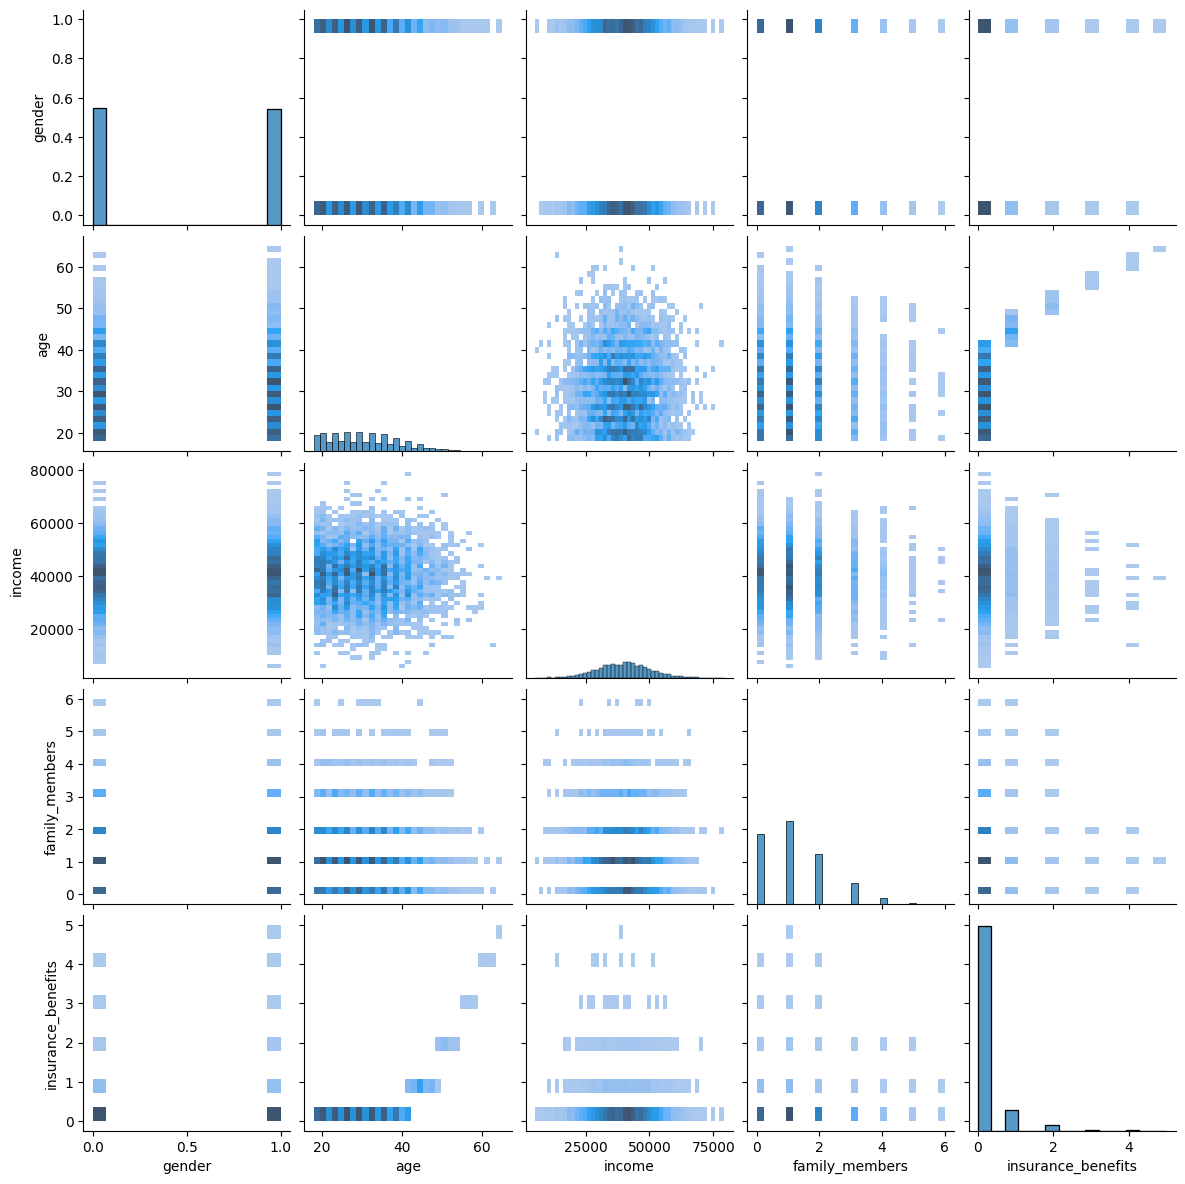

In [16]:
main_df_pair_plot = sns.pairplot(main_df, kind = 'hist')
main_df_pair_plot.fig.set_size_inches(12, 12)

Unfortunately, it is rather difficult to identify any obvious groups from the above pair plot. Maybe looking at the correlation values is a good idea?

In [17]:
main_df.corr()

,gender,age,income,family_members,insurance_benefits
gender,1.000000,0.001953,0.015456,-0.007315,0.011565
age,0.001953,1.000000,-0.017386,-0.009064,0.654964
income,0.015456,-0.017386,1.000000,-0.031687,-0.013123
family_members,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
insurance_benefits,0.011565,0.654964,-0.013123,-0.039303,1.000000


Sadly, the above correlation values are not very useful. 

The only correlation that is moderately strong, which a value of 0.654964, is the one between **age** and **insurance_benefits**. This implies that a customer's age is a moderately good predictor of how many insurance benefits the customer receives. Since the correlation is positive, that means older customers tend to receive a larger number of benefits than younger customers. 

Every other correlation value has an absolute value less than 0.1, meaning virtually no correlation between the features. I need to find a way to combine several variables simultaneously in order to reveal useful insights. Thankfully, Linear Algebra and Machine Learning are effective at this.

# Task 1: Similar Customers <a id = 3></a>

One way to identify objects that make sense to group together, because they are very similar, is to develop a procedure (using machine learning) that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

Here, I will write a function that returns the k nearest neighbors for an $n^{th}$ object based on a specified distance metric (either Euclidean or Manhattan). The number of received insurance benefits will not be taken into account for this task, since that is the target. 

The function will be tested using every possible combination of the following:

<b>Scaling:</b>
  - The data is not scaled
  - The data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler

<b>Distance Metrics:</b>
  - Euclidean
  - Manhattan

I will also answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric, regardless of the scaling?

In [18]:
features_names = ['gender', 'age', 'income', 'family_members']

In the next line, I define the function **get_knn** where...

- parameter df: The pandas DataFrame used to find similar objects within.
- parameter n: The object number for which the nearest neighbours are looked for.
- parameter k: The number of nearest neighbours to return.
- parameter metric: The name of distance metric (Euclidean or Manhattan)

In [19]:
def get_knn(df, n, k, metric):
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors = k, metric = metric)
    nbrs.fit(df[features_names].values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][features_names]], k, return_distance = True)
    
    df_res = pd.concat([df.iloc[nbrs_indices[0]], 
                        pd.DataFrame(nbrs_distances.T, index = nbrs_indices[0], columns = ['distance'])], axis = 1)
    
    return df_res

Now let's scale the data.

In [20]:
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(main_df[features_names].to_numpy())

main_df_scaled = main_df.copy()
main_df_scaled.loc[:, features_names] = transformer_mas.transform(main_df[features_names].to_numpy())

C:\Users\18604\AppData\Local\Temp\ipykernel_33668\340739115.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  main_df_scaled.loc[:, features_names] = transformer_mas.transform(main_df[features_names].to_numpy())
C:\Users\18604\AppData\Local\Temp\ipykernel_33668\340739115.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.6278481  0.48101266 0.26582278 ... 0.42911392 0.41392405 0.51392405]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  main_df_scaled.loc[:, features_names] = transformer_mas.transform(main_df[features_names].to_numpy())
C:\Users\18604\AppData\Local\Temp\ipykernel_33668\340739115.py:4: FutureWarning: Setting an item of inco

In [21]:
display(main_df_scaled.sample(10))
print()
print(main_df_scaled.info())

,gender,age,income,family_members,insurance_benefits
4578,0,0.630769,0.598734,0.333333,0
2898,1,0.430769,0.479747,0.000000,0
2139,1,0.369231,0.583544,0.333333,0
575,1,0.523077,0.441772,0.000000,0
4671,0,0.707692,0.611392,0.000000,1
3461,0,0.446154,0.430380,0.333333,0
2053,0,0.446154,0.440506,0.000000,0
2221,0,0.461538,0.606329,0.166667,0
3188,1,0.615385,0.736709,0.000000,0
4154,0,0.323077,0.481013,0.000000,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   float64
 2   income              4847 non-null   float64
 3   family_members      4847 non-null   float64
 4   insurance_benefits  4847 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 189.5 KB
None


It looks like the data was correctly scaled! Now let's test the **get_knn** function for every combination of scaling and distance metrics.

Specifically, I will set n = 0 and k = 11 in order to find the 10 customers who are most similar to the first customer in the dataframe. (The reason why k needs to be set equal to 11 instead of 10 is because the first customer, n = 0, is counted as one of the 11.)

In [22]:
not_scaled_euclidean = get_knn(main_df[features_names], 0, 11, 'euclidean')
display(not_scaled_euclidean)

,gender,age,income,family_members,distance
0,1,41,49600,1,0.000000
1992,1,41,49600,0,1.000000
1214,0,42,49600,0,1.732051
3916,1,44,49600,2,3.162278
3334,0,38,49600,0,3.316625
810,1,37,49600,2,4.123106
4520,0,45,49600,0,4.242641
2094,0,37,49600,2,4.242641
2311,1,46,49600,2,5.099020
3790,1,36,49600,0,5.099020


In [23]:
scaled_euclidean = get_knn(main_df_scaled[features_names], 0, 11, 'euclidean')
display(scaled_euclidean)

,gender,age,income,family_members,distance
0,1,0.630769,0.627848,0.166667,0.000000
2632,1,0.630769,0.634177,0.166667,0.006329
133,1,0.615385,0.636709,0.166667,0.017754
4720,1,0.646154,0.637975,0.166667,0.018418
3192,1,0.646154,0.651899,0.166667,0.028550
1550,1,0.615385,0.602532,0.166667,0.029624
2072,1,0.630769,0.596203,0.166667,0.031646
124,1,0.661538,0.635443,0.166667,0.031693
3541,1,0.615385,0.600000,0.166667,0.031815
3099,1,0.600000,0.611392,0.166667,0.034893


In [24]:
not_scaled_manhattan = get_knn(main_df[features_names], 0, 11, 'manhattan')
display(not_scaled_manhattan)

,gender,age,income,family_members,distance
0,1,41,49600,1,0.0
1992,1,41,49600,0,1.0
1214,0,42,49600,0,3.0
3916,1,44,49600,2,4.0
3334,0,38,49600,0,5.0
810,1,37,49600,2,5.0
4520,0,45,49600,0,6.0
2094,0,37,49600,2,6.0
2311,1,46,49600,2,6.0
3790,1,36,49600,0,6.0


In [25]:
scaled_manhattan = get_knn(main_df_scaled[features_names], 0, 11, 'manhattan')
display(scaled_manhattan)

,gender,age,income,family_members,distance
0,1,0.630769,0.627848,0.166667,0.000000
2632,1,0.630769,0.634177,0.166667,0.006329
133,1,0.615385,0.636709,0.166667,0.024245
4720,1,0.646154,0.637975,0.166667,0.025511
2072,1,0.630769,0.596203,0.166667,0.031646
124,1,0.661538,0.635443,0.166667,0.038364
4173,1,0.630769,0.588608,0.166667,0.039241
3192,1,0.646154,0.651899,0.166667,0.039435
1550,1,0.615385,0.602532,0.166667,0.040701
3541,1,0.615385,0.600000,0.166667,0.043233


**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Oh, absolutely it does! The distances are much smaller when the data is scaled, regardless of the distance metric.

When the data is not scaled, the 10 shortest distances using the euclidean metric range from 1 to 8.062258, and using the manhattan metric the 10 shortest distances range from 1 to 9.

In contrast, when the data is scaled all 10 shortest distances are less than 1 (in fact, all 10 shortest distances are much closer to 0 than to 1). The euclidean metric distances range from 0.006329 to 0.036156 and the manhattan metric distances range from 0.006329 to 0.047225.

I think the **income** column is the main reason why the data being not scaled affects the kNN algorithm. In the original (i.e. not scaled) dataframe, the income values have a much larger magnitude than the other features, and thus the income column influences the distances much more than the other features.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Let's store the distance values and their corresponding indexes into new dataframes to make comparing the results easy.

In [26]:
index_and_distance_not_scaled_df = pd.DataFrame()

index_and_distance_not_scaled_df['index_not_scaled_euc'] = not_scaled_euclidean.index
index_and_distance_not_scaled_df['index_not_scaled_man'] = not_scaled_manhattan.index
index_and_distance_not_scaled_df['same_index'] = (index_and_distance_not_scaled_df['index_not_scaled_euc'] == index_and_distance_not_scaled_df['index_not_scaled_man']).map({True: 'Yes', False: 'No'})

index_and_distance_not_scaled_df['distance_not_scaled_euc'] = not_scaled_euclidean['distance'].values
index_and_distance_not_scaled_df['distance_not_scaled_man'] = not_scaled_manhattan['distance'].values
index_and_distance_not_scaled_df['distance_difference'] = index_and_distance_not_scaled_df['distance_not_scaled_man'] - index_and_distance_not_scaled_df['distance_not_scaled_euc']

index_and_distance_not_scaled_df.drop(index_and_distance_not_scaled_df.index[0], inplace = True)

display(index_and_distance_not_scaled_df)

,index_not_scaled_euc,index_not_scaled_man,same_index,distance_not_scaled_euc,distance_not_scaled_man,distance_difference
1,1992,1992,Yes,1.000000,1.0,0.000000
2,1214,1214,Yes,1.732051,3.0,1.267949
3,3916,3916,Yes,3.162278,4.0,0.837722
4,3334,3334,Yes,3.316625,5.0,1.683375
5,810,810,Yes,4.123106,5.0,0.876894
6,4520,4520,Yes,4.242641,6.0,1.757359
7,2094,2094,Yes,4.242641,6.0,1.757359
8,2311,2311,Yes,5.099020,6.0,0.900980
9,3790,3790,Yes,5.099020,6.0,0.900980
10,3590,3590,Yes,8.062258,9.0,0.937742


For the most part, when the data is not scaled the euclidean and manhattan metrics yield very similar results. In fact, 7 out of the 10 shortest distances for both metrics have the same index, meaning 7 out of the 10 customers nearest to the first customer are not only the same people for both metrics, but also those 7 people are located in the same slot.

As for the 3 customers not in the exact same slot (index values 2094, 3790, and 2311), they are all nevertheless present in a nearby slot. For example, the customer with index 3790 is the 8th nearest customer when using the euclidean metric, and is the 9th nearest customer when using the manhattan metric.

Lastly, the distances are all quite similar. Manhattan distance is always greater than or equal to euclidean distance, never less than, so it makes sense that most of the manhattan distances are slightly larger. Thankfully, all of the manhattan distances are less than 2 units larger than the euclidean distances.

In [27]:
index_and_distance_scaled_df = pd.DataFrame()

index_and_distance_scaled_df['index_scaled_euc'] = scaled_euclidean.index
index_and_distance_scaled_df['index_scaled_man'] = scaled_manhattan.index
index_and_distance_scaled_df['same_index'] = (index_and_distance_scaled_df['index_scaled_euc'] == index_and_distance_scaled_df['index_scaled_man']).map({True: 'Yes', False: 'No'})

index_and_distance_scaled_df['distance_scaled_euc'] = scaled_euclidean['distance'].values
index_and_distance_scaled_df['distance_scaled_man'] = scaled_manhattan['distance'].values
index_and_distance_scaled_df['distance_difference'] = index_and_distance_scaled_df['distance_scaled_man'] - index_and_distance_scaled_df['distance_scaled_euc']


index_and_distance_scaled_df.drop(index_and_distance_scaled_df.index[0], inplace = True)

display(index_and_distance_scaled_df)

,index_scaled_euc,index_scaled_man,same_index,distance_scaled_euc,distance_scaled_man,distance_difference
1,2632,2632,Yes,0.006329,0.006329,0.000000
2,133,133,Yes,0.017754,0.024245,0.006492
3,4720,4720,Yes,0.018418,0.025511,0.007093
4,3192,2072,No,0.028550,0.031646,0.003095
5,1550,124,No,0.029624,0.038364,0.008740
6,2072,4173,No,0.031646,0.039241,0.007595
7,124,3192,No,0.031693,0.039435,0.007743
8,3541,1550,No,0.031815,0.040701,0.008886
9,3099,3541,No,0.034893,0.043233,0.008340
10,69,3099,No,0.036156,0.047225,0.011069


Unfortunately, the indexes are not as similar when using the scaled data. The top 3 shortest distance customers (index values 2632, 133, and 4720) are the same for both metrics, but only those 3. 

On the bright side, both metrics identified 6 additional customers as being somewhere in the top 10: those with index values, in order from least to greatest, 124, 1550, 2072, 3099, 3192, 3541. 

Interestingly, the customer with index 69 got 10th place when using euclidean distance, but does not appear anywhere in the top 10 using manhattan distance. Furthermore, the customer with index 4173 only appears in the top 10 using manhattan distance,  in 6th place. 

Lastly, I should mention that the distance values are extremely similar. The <b><i>largest</b></i> difference in distance is 0.011069, which is still very close to 0. 

# Task 2: Is The Customer Likely to Receive Insurance Benefits? <a id = 4></a>

The above question can be treated as a binary classification task, since either a customer receives insurance benefits or does not.

With `insurance_benefits` being more than zero as the target, I wonder if kNN classification can do better than a dummy model.

I will now follow these instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for parameter **n_neighbors** = 1 through 10 for both the original data and the scaled one. (It would be interesting to see how k influences the evaluation metric, and whether scaling the data makes any difference.)
- Build a dummy model which is just random for this case. It should return "1" with some probability. Let's test the dummy model with four probability values: 0, the value of the probability of receiving any insurance benefit, 0.5, and 1.

The probability of receiving any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of customers who received any insurance benefit}}{\text{total number of customers}}.
$$

I will split the whole data using a 70:30 ratio for the training and test sets.

The next line adds a new column to the **main_df**, which indicates whether or not a customer received at least 1 benefit.

In [28]:
main_df['insurance_benefits_received'] = main_df['insurance_benefits'].apply(lambda x: 
                                                                             'No' if x == 0 
                                                                             else 'Yes')

I worry that there is a serious class imbalance with the **insurance_benefits_received** values. Let's see if there is... 

In [29]:
main_df['insurance_benefits_received'].value_counts()

insurance_benefits_received
No     4284
Yes     563
Name: count, dtype: int64

Indeed, there is a class imbalance because there are <b><i>far more</b></i> customers who receive no benefits than there are customers who receive at least one benefit. Thankfully, this can be remedied using the **stratify** parameter of **train_test_split**. Let's split the original data into training and test sets using a 70:30 ratio.

In [30]:
not_scaled_train, not_scaled_test = train_test_split(main_df, test_size = 0.3, 
                                                     stratify = main_df['insurance_benefits_received'], 
                                                     random_state = 12345)

not_scaled_train_features = not_scaled_train[features_names].copy()
not_scaled_train_targets = not_scaled_train['insurance_benefits_received'].copy()

not_scaled_test_features = not_scaled_test[features_names].copy()
not_scaled_test_targets = not_scaled_test['insurance_benefits_received'].copy()

Now let's test a KNN classifier by finding the F1 score and the confusion matrix when the **n_neighbors** parameter is set equal to every integer between 1 and 10, inclusive.

In [31]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, pos_label = 'Yes')
    print(f'F1: {f1_score:.2f}')
    
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print(confusion_matrix)

In [32]:
for integer in range(1, 11):
    print('F1 score and confusion matrix for n_neighbors =', integer)
    knn_not_scaled = sklearn.neighbors.KNeighborsClassifier(n_neighbors = integer)
    knn_not_scaled.fit(not_scaled_train_features, not_scaled_train_targets)
    eval_classifier(not_scaled_test_targets, knn_not_scaled.predict(not_scaled_test_features))
    print()

F1 score and confusion matrix for n_neighbors = 1
F1: 0.66
Confusion Matrix
[[1255   31]
 [  70   99]]

F1 score and confusion matrix for n_neighbors = 2
F1: 0.35
Confusion Matrix
[[1281    5]
 [ 132   37]]

F1 score and confusion matrix for n_neighbors = 3
F1: 0.40
Confusion Matrix
[[1268   18]
 [ 122   47]]

F1 score and confusion matrix for n_neighbors = 4
F1: 0.19
Confusion Matrix
[[1282    4]
 [ 151   18]]

F1 score and confusion matrix for n_neighbors = 5
F1: 0.20
Confusion Matrix
[[1276   10]
 [ 149   20]]

F1 score and confusion matrix for n_neighbors = 6
F1: 0.12
Confusion Matrix
[[1284    2]
 [ 158   11]]

F1 score and confusion matrix for n_neighbors = 7
F1: 0.13
Confusion Matrix
[[1282    4]
 [ 157   12]]

F1 score and confusion matrix for n_neighbors = 8
F1: 0.06
Confusion Matrix
[[1286    0]
 [ 164    5]]

F1 score and confusion matrix for n_neighbors = 9
F1: 0.06
Confusion Matrix
[[1285    1]
 [ 164    5]]

F1 score and confusion matrix for n_neighbors = 10
F1: 0.00
Conf

For the most part, the F1 score decreases as the value of **n_neighbors** increases. The best F1 score, by far, is 0.65 which occurs when **n_neighbors** = 1. 

In fact, this is the only F1 score that is greater than 0.5, which suggests that the balance between precision and recall is pretty good (but not great).

Now let's do the same with the scaled data!

In [33]:
scaled_train, scaled_test = train_test_split(main_df, test_size = 0.3, 
                                             stratify = main_df['insurance_benefits_received'], 
                                             random_state = 12345)

scaled_train_features = scaled_train[features_names].copy()
scaled_train_features.loc[:, features_names] = transformer_mas.fit_transform(scaled_train_features)

scaled_train_targets = scaled_train['insurance_benefits_received'].copy()

scaled_test_features = scaled_test[features_names].copy()
scaled_test_features.loc[:, features_names] = transformer_mas.transform(scaled_test_features.to_numpy())

scaled_test_targets = scaled_test['insurance_benefits_received'].copy()

C:\Users\18604\AppData\Local\Temp\ipykernel_33668\3154835995.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.35384615 0.4        0.56923077 ... 0.4        0.29230769 0.56923077]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  scaled_train_features.loc[:, features_names] = transformer_mas.fit_transform(scaled_train_features)
C:\Users\18604\AppData\Local\Temp\ipykernel_33668\3154835995.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.5837766  0.63696809 0.56515957 ... 0.59441489 0.49867021 0.65957447]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  scaled_train_features.loc[:, features_names] = transformer_mas.fit_transform(scaled_train_features)
C:\Users\18604\AppData\Local\Temp\ipykernel_33668\3154835995.py:6: FutureWarning: Setting an item of incom

In [34]:
for integer in range(1, 11):
    print('F1 score and confusion matrix for n_neighbors =', integer)
    knn_scaled = sklearn.neighbors.KNeighborsClassifier(n_neighbors = integer)
    knn_scaled.fit(scaled_train_features, scaled_train_targets)
    eval_classifier(scaled_test_targets, knn_scaled.predict(scaled_test_features))
    print()

F1 score and confusion matrix for n_neighbors = 1
F1: 0.95
Confusion Matrix
[[1280    6]
 [  11  158]]

F1 score and confusion matrix for n_neighbors = 2
F1: 0.92
Confusion Matrix
[[1285    1]
 [  25  144]]

F1 score and confusion matrix for n_neighbors = 3
F1: 0.94
Confusion Matrix
[[1279    7]
 [  14  155]]

F1 score and confusion matrix for n_neighbors = 4
F1: 0.90
Confusion Matrix
[[1283    3]
 [  29  140]]

F1 score and confusion matrix for n_neighbors = 5
F1: 0.93
Confusion Matrix
[[1280    6]
 [  17  152]]

F1 score and confusion matrix for n_neighbors = 6
F1: 0.92
Confusion Matrix
[[1285    1]
 [  23  146]]

F1 score and confusion matrix for n_neighbors = 7
F1: 0.94
Confusion Matrix
[[1283    3]
 [  17  152]]

F1 score and confusion matrix for n_neighbors = 8
F1: 0.92
Confusion Matrix
[[1284    2]
 [  22  147]]

F1 score and confusion matrix for n_neighbors = 9
F1: 0.94
Confusion Matrix
[[1283    3]
 [  17  152]]

F1 score and confusion matrix for n_neighbors = 10
F1: 0.91
Conf

Great! These are fantastic results! Just like how the scaled data got much better results in Task 1, in the form of much shortest distances, the scaled data also has much better results in this task. I think it is fantastic to see that all 10 confusion matrices of the scaled data correspond to an F1 score that is at least 0.9. Since all of the F1 scores are so close to 1, that implies an excellent balance between precision and recall. The practical takeaway from this is that <u>Sure Tomorrow</u> can use the scaled data to identify at least 10 (possibly more) neighbors for any given customer with a high degree of accuracy.

Now it's time for the dummy model. The very next line generates the outputs of a random (dummy) model.

In [35]:
def rnd_model_predict(P, size, seed = 42):

    rng = np.random.default_rng(seed = seed)
    return rng.binomial(n = 1, p = P, size = size)

In [36]:
for p_value in [0, main_df['insurance_benefits_received'].value_counts()['Yes'] / len(main_df), 0.5, 1]:

    print(f'The probability: {p_value:.2f}')
    y_pred_rnd = rnd_model_predict(p_value, main_df['insurance_benefits_received'].shape[0])
    y_pred_rnd = ['Yes' if pred == 1 else 'No' for pred in y_pred_rnd]
    
    eval_classifier(main_df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[4284    0]
 [ 563    0]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[3805  479]
 [ 493   70]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[2175 2109]
 [ 287  276]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[   0 4284]
 [   0  563]]



The very best dummy model has an F1 score of 0.21, which is worse than even the original data has **n_neighbors** set equal to 1, 2, or 3.

Perhaps it goes without saying, but the dummy model is nowhere near as good as the KNN classifier when using the scaled data. This is, of course, great news because there would be no point in using a model that isn't significantly better than a dummy.

# Task 3: Linear Regression <a id = 5></a>

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — Feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — Target (a vector)
- $\hat{y}$ — Estimated tagret (a vector)
- $w$ — Weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data into the ratio 70:30 for the training and test sets. Use the RMSE metric for the model evaluation.

In [37]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X_feature, y_target):
        
        X2_feature = np.append(np.ones([len(X_feature), 1]), X_feature, axis = 1)
        self.weights = np.linalg.inv(X2_feature.T.dot(X2_feature)).dot(X2_feature.T).dot(y_target)

    def predict(self, X_feature):
        
        X2_feature = np.append(np.ones([len(X_feature), 1]), X_feature, axis = 1)
        y_pred = X2_feature.dot(self.weights)
        
        return y_pred

In [38]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

I am now ready to test the linear regression on the original data.

In [39]:
X_feature_od = main_df[features_names].to_numpy()
y_target_od = main_df['insurance_benefits'].to_numpy()

X_feature_od_train, X_feature_od_test, y_target_od_train, y_target_od_test = train_test_split(X_feature_od, y_target_od, 
                                                                                              test_size = 0.3, 
                                                                                              random_state = 12345)

not_scaled_lr = MyLinearRegression()
not_scaled_lr.fit(X_feature_od_train, y_target_od_train)

print(not_scaled_lr.weights)

y_target_od_test_pred = not_scaled_lr.predict(X_feature_od_test)
eval_regressor(y_target_od_test, y_target_od_test_pred)

[-9.77366679e-01  1.95594897e-02  3.58042290e-02  5.85335011e-07
 -1.21618426e-02]
RMSE: 0.36
R2: 0.66


Now let's see what RMSE and R2 values the scaled data gives us.

In [40]:
X_feature_sd_train, X_feature_sd_test, y_target_sd_train, y_target_sd_test = train_test_split(X_feature_od, y_target_od, 
                                                                                              test_size = 0.3, 
                                                                                              random_state = 12345)


X_feature_sd_train = transformer_mas.fit_transform(X_feature_sd_train)
X_feature_sd_test = transformer_mas.transform(X_feature_sd_test)

scaled_lr = MyLinearRegression()
scaled_lr.fit(X_feature_sd_train, y_target_sd_train)

print(scaled_lr.weights)

y_target_sd_test_pred = scaled_lr.predict(X_feature_sd_test)
eval_regressor(y_target_sd_test, y_target_sd_test_pred)

[-0.97736668  0.01955949  2.32727489  0.04378306 -0.07297106]
RMSE: 0.36
R2: 0.66


Really? Fascinating... I was expecting the scaled data to yield a smaller RMSE value and a larger R2 value than the original data, but (despite having different values in the resulting vectors) instead these values are exactly the same. Though the scaled data was the clear "winner" in Tasks 1 and 2, in this task I am not sure how to tell which of the two data sets is better to use.

# Task 4: Obfuscating Data <a id = 6></a>

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = XP
$$

I will do that and then check how the features' values look after the transformation. It is imperative that I make sure $P$ is invertible.

In [41]:
main_df_pn = main_df[features_names].copy()

In [42]:
X_matrix = main_df_pn.to_numpy()

Have the values of the dataframe been correctly put into the matrix? Let's see if the first 10 rows match.

In [43]:
print(main_df_pn.head(10))

   gender  age  income  family_members
0       1   41   49600               1
1       0   46   38000               1
2       0   29   21000               0
3       0   21   41700               2
4       1   28   26100               0
5       1   43   41000               2
6       1   39   39700               2
7       1   25   38600               4
8       1   36   49700               1
9       1   32   51700               1


In [44]:
print(X_matrix[:10])

[[    1    41 49600     1]
 [    0    46 38000     1]
 [    0    29 21000     0]
 [    0    21 41700     2]
 [    1    28 26100     0]
 [    1    43 41000     2]
 [    1    39 39700     2]
 [    1    25 38600     4]
 [    1    36 49700     1]
 [    1    32 51700     1]]


Yes they have (been correctly put into the matrix)! 

Now let's generate a random matrix $P$.

In [45]:
rng = np.random.default_rng(seed = 42)
P_matrix = rng.random(size = (X_matrix.shape[1], X_matrix.shape[1]))

Is the matrix $P$ invertible?

In [46]:
print('The matrix P is:')
print(P_matrix)
print()
print('The (apparent) inverse of matrix P is:')
print(np.linalg.inv(P_matrix))

The matrix P is:
[[0.77395605 0.43887844 0.85859792 0.69736803]
 [0.09417735 0.97562235 0.7611397  0.78606431]
 [0.12811363 0.45038594 0.37079802 0.92676499]
 [0.64386512 0.82276161 0.4434142  0.22723872]]

The (apparent) inverse of matrix P is:
[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


It appears as though $P$ is indeed invertible. If I now multiply $P$ by its apparent inverse, then I should get the identity matrix. (The identity matrix is the one where all of the numbers in the main diagonal are 1, and every other number is 0.)

Oftentimes when doing this kind of operation, the numbers that are not in the main diagonal are not exactly 0, but rather extremely close to 0. The code below will print the product of the matrices in such a way that all the numbers are rounded to the nearest integer.

In [47]:
np.set_printoptions(suppress = True)

print('The product of matrix P and its (apparent) inverse is:')
print(np.round(P_matrix @ np.linalg.inv(P_matrix)).astype(int))

The product of matrix P and its (apparent) inverse is:
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


Excellent! I acquired the identity matrix, as I hoped I would!

Can I guess the customers' ages or income after the transformation?

Recall that I printed the first 10 rows of the matrix earlier. If the transformation works correctly, then it would be extremely difficult, if not impossible, to correctly guess the gender, age, income, and family members values of the first 10 rows, and really all of the rows, after the transformation.

In [48]:
np.set_printoptions(suppress = False)

print('The first 10 rows of the matrix before the transformation:')
print(X_matrix[:10])
print()
print('The first 10 rows of the matrix after the transformation:')
print((X_matrix @ P_matrix)[:10])

The first 10 rows of the matrix before the transformation:
[[    1    41 49600     1]
 [    0    46 38000     1]
 [    0    29 21000     0]
 [    0    21 41700     2]
 [    1    28 26100     0]
 [    1    43 41000     2]
 [    1    39 39700     2]
 [    1    25 38600     4]
 [    1    36 49700     1]
 [    1    32 51700     1]]

The first 10 rows of the matrix after the transformation:
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]
 [ 5258.77025195 18509.8596165  15237.19342704 38032.31715339]
 [ 5091.84582008 17920.45540783 14752.11143673 36824.37841067]
 [ 4950.8900715  17413.01768645 14334.46448264 35794.3865001 ]
 [ 6372.05574967 22420.56515812 18457.36484575 46089.44286752]
 [ 6627.90630563 23317.43454451 19195.916335

Perfect! To give just one example of how difficult it now is to guess any of the features values of a customer, before the transformation 3 of the customers in the first 10 rows have a gender value of 0, and after the transformation the gender values of those 3 customers are now 4873.29406479, 2693.11742928, and 5345.60393712. I doubt anyone would recognize that those three very different numbers are actually associated with the same gender.

Can I recover the original data from $X'$ if I know $P$? I should be able to by multiplying $X'$ by the inverse of $P$.

In [49]:
np.set_printoptions(suppress = True)

print(np.round(X_matrix @ P_matrix @ np.linalg.inv(P_matrix))[:10].astype(int))

[[    1    41 49600     1]
 [    0    46 38000     1]
 [    0    29 21000     0]
 [    0    21 41700     2]
 [    1    28 26100     0]
 [    1    43 41000     2]
 [    1    39 39700     2]
 [    1    25 38600     4]
 [    1    36 49700     1]
 [    1    32 51700     1]]


Excellent! I successfully recovered the first 10 rows of the original data, which suggests to me that I should be able to recover the whole matrix if need be.

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

Oh, I actually already did this. However, let's do it again without any rounding. Since the directions ask for only a "few" customers, let's look at the last 4.

In [50]:
np.set_printoptions(suppress = False)

print('The last 4 rows of the original dataframe\'s features columns:')
print(main_df_pn.tail(4))
print()
print('The last 4 rows of the matrix before the transformation:')
print(X_matrix[-4:])
print()
print('The last 4 rows of the matrix after the transformation:')
print((X_matrix @ P_matrix)[-4:])
print()
print('The last 4 rows of the matrix after reversing the transformation:')
print((X_matrix @ P_matrix @ np.linalg.inv(P_matrix))[-4:])

The last 4 rows of the original dataframe's features columns:
      gender  age  income  family_members
4843       0   34   52400               1
4844       0   20   33900               2
4845       1   22   32700               3
4846       1   28   40600               1

The last 4 rows of the matrix before the transformation:
[[    0    34 52400     1]
 [    0    20 33900     2]
 [    1    22 32700     3]
 [    1    28 40600     1]]

The last 4 rows of the matrix after the transformation:
[[ 6717.00024715 23634.2170673  19456.13863385 48589.43884077]
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

The last 4 rows of the matrix after reversing the transformation:
[[-1.18234311e-11  3.40000000e+01  5.24000000e+04  1.00000000e+00]
 [ 9.09494702e-13  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04 

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Indeed, some of the values are not <b><i>exactly</b></i> the same, but they are similar enough that I should not be worried. I think some of the values are slightly off because the transformation caused many of the values of the matrix to go from being integers to floats that have many decimal places, and it is difficult to precisely multiply numbers that have so many decimal places.

<b>Proof That Data Obfuscation Can Work with Linear Regression</b> <a id = 6.1></a>

The regression task has been solved with linear regression in this project. I must now prove <b>_analytically_</b> that the given obfuscation method won't affect the linear regression in terms of the predicted values (i.e. their values will remain the same).

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

The proof begins with the assumption that $w_P = [(XP)^T XP]^{-1} (XP)^T y$

I hope to show that $w$ and $w_P$ are linked by demonstrating that the expression for $w$ can be substituted into $w_P$ after using properties of matrices to rearrange the expression for $w_P$ in particular ways.

Since $(XP)^T$ = $P^TX^T$, then $w_P = [(XP)^T XP]^{-1} (XP)^T y = [P^TX^T XP]^{-1} P^TX^T y$

Furthermore, $[P^TX^T XP]^{-1} = P^{-1}(X^T X)^{-1}(P^{T})^{-1}$ meaning $w_P = [P^TX^T XP]^{-1} P^TX^T y = P^{-1}(X^T X)^{-1}(P^{T})^{-1} P^TX^T y$

Note that $(P^{T})^{-1} P^T = I$ (the identity matrix), which implies $w_P = P^{-1}(X^T X)^{-1}(P^{T})^{-1} P^TX^T y = P^{-1}(X^T X)^{-1}IX^T y = P^{-1}(X^T X)^{-1}X^T y$

Next, I realized that because $w = (X^T X)^{-1} X^T y$ then $w_P = P^{-1}(X^T X)^{-1}X^T y = P^{-1}w$

Therefore, I have demonstrated that $w$ and $w_P$ can be linked!

What would be predicted values with $w_P$? 

Let's begin by mentioning that $A = Xw$ and $A′ = X′w_p$

Since $X′ = XP$ (this was mentioned earlier) and $w_P = P^{-1}w$ then $A′ = X′w_p = XPP^{-1}w = Xw = A$

What does that mean for the quality of linear regression if you measure it with RMSE?

Since A and A′ are equal, then the RMSE (which was calculated in Task 3) for both the original and the transformed datasets will be the same.

<b>Test the Linear Regression With Data Obfuscation</b> <a id = 6.2></a>

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

I will build a procedure that runs the Linear Regression optionally with the obfuscation.

I will run a Linear Regression for both the original data and the obfuscated, then compare the predicted values, the RMSE values, and the $R^2$ metric values.

<u>Procedure</u>

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use $XP$ as the new feature matrix.
- Test both the original data and the obfuscated data using a Linear Regression.

In [51]:
new_rng = np.random.default_rng(seed = 42)
new_P_matrix = rng.random(size = (X_matrix.shape[1], X_matrix.shape[1]))

In [52]:
print('The (new) matrix P is:')
print(new_P_matrix)
print()
print('The (apparent) inverse of (the new) matrix P is:')
print(np.linalg.inv(new_P_matrix))

The (new) matrix P is:
[[0.55458479 0.06381726 0.82763117 0.6316644 ]
 [0.75808774 0.35452597 0.97069802 0.89312112]
 [0.7783835  0.19463871 0.466721   0.04380377]
 [0.15428949 0.68304895 0.74476216 0.96750973]]

The (apparent) inverse of (the new) matrix P is:
[[-3.30407744  4.40917525 -0.27870525 -1.90039547]
 [-0.95858897 -1.33121709  1.62644533  1.78106755]
 [ 6.24868421 -7.35167522  2.19103126  2.60761164]
 [-3.6064091   5.89580272 -2.79039845 -1.92803822]]


It does seem as though the new matrix $P$ is invertible. Let's see if the product of $P$ and its (apparent) inverse is the identity matrix (as it should be).

In [53]:
np.set_printoptions(suppress = True)

print('The product of (the new) matrix P and its (apparent) inverse is:')
print(np.round(new_P_matrix @ np.linalg.inv(new_P_matrix)).astype(int))

The product of (the new) matrix P and its (apparent) inverse is:
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


Excellent! This confirms that I may use $XP$ as the new feature matrix!

In [54]:
main_df_pn_new = main_df[features_names].copy()

The features and the targets are the following:

In [55]:
X_feature_new = main_df_pn_new.to_numpy()
y_target_new = main_df['insurance_benefits'].to_numpy()

Now I'm ready to use a Linear Regression on the original data.

In [56]:
X_feature_new_train, X_feature_new_test, y_target_new_train, y_target_new_test = train_test_split(
    X_feature_new, y_target_new, test_size = 0.3, random_state = 12345)

new_lr_og_data = MyLinearRegression()
new_lr_og_data.fit(X_feature_new_train, y_target_new_train)

print(new_lr_og_data.weights)

y_target_new_test_pred = new_lr_og_data.predict(X_feature_new_test)
eval_regressor(y_target_new_test, y_target_new_test_pred)

[-0.97736668  0.01955949  0.03580423  0.00000059 -0.01216184]
RMSE: 0.36
R2: 0.66


Let's see if I get the same RMSE and R2 values with the obfuscated data.

In [57]:
X_feature_new_prime = X_feature_new @ new_P_matrix

X_feature_new_train_ob, X_feature_new_test_ob, y_target_new_train_ob, y_target_new_test_ob = train_test_split(
    X_feature_new_prime, y_target_new, test_size = 0.3, random_state = 12345)

new_lr_ob_data = MyLinearRegression()
new_lr_ob_data.fit(X_feature_new_train_ob, y_target_new_train_ob)

print(new_lr_ob_data.weights)

y_target_new_test_ob_pred = new_lr_ob_data.predict(X_feature_new_test_ob)
eval_regressor(y_target_new_test_ob, y_target_new_test_ob_pred)

[-0.9773666   0.11635627 -0.08807214 -0.17271779  0.16400536]
RMSE: 0.36
R2: 0.66


Fantastic! The fact that the RMSE and R2 values are the same implies that the data obfuscation does not impact the model's quality.

This means that <u>Sure Tomorrow</u> is able to protect the personal details of its clients without needing to worry about this compromising the model's accuracy!

# Conclusion <a id = 7></a>

I have successfully solved all four tasks that <u>Sure Tomorrow</u> assigned me.

<b>Task 1:</b> I wrote a function that returns the k nearest neighbors of a given customer. In particular, I discovered that scaling the data allows the function to make the distance between the 10 (if not more) nearest neighbors of a particular customer close to 0. This function will really help the company figure out how to effectively market its services to people of similar demographics.  

<b>Task 2:</b> I successfully build a high-quality KNN-based classifier that can predict with a high degree of accuracy whether or not a new customer is likely to receive an insurance benefit. Specifically, when using the scaled data with the classifier, it has an F1 score at least 0.9 for all n_neighbors values between 1 and 10 inclusive. This is far superior to even the best dummy model, which has an F1 score of 0.21.

<b>Task 3:</b> I used a linear regression model to predict the number of insurance benefits a new customer is likely to receive. The linear regression has an RMSE value of 0.36 (which is very small, as we would want it to be) and an R2 value of 0.66 (which is moderately large, also a good thing). These values were obtained regardless of whether the original or the scaled data was used.

<b>Task 4:</b> I demonstrated that the linear regression model from Task 3 works equally as well after the customers' personal data received protection using data obfuscation as it did before. Thanks to the data obfuscation, it is now difficult for a malicious person or persons to acquire a customer's personal information if the data were to fall into their possession.

# Appendices <a id = 8></a>

<b>Appendix A: Writing Formulas in Jupyter Notebooks</b>

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

<b>Appendix B: Properties of Matrices</b>

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>